In [ ]:
!pip install nvitop

     |████████████████████████████████| 71kB 8.4MB/s 
  Created wheel for nvidia-ml-py: filename=nvidia_ml_py-11.450.51-cp37-none-any.whl size=24235 sha256=78727b98cb779a3abd71c85e8dee052316c8019ccc50c27b720f18a4e04fa918
  Stored in directory: /root/.cache/pip/wheels/98/bf/a0/2ccfd4ff2f7b98e64f29b57149ddf9cd59d298d583ba9040a3
Successfully built nvidia-ml-py


In [ ]:
!nvitop

Wed Jun 16 15:29:19 2021
╒═════════════════════════════════════════════════════════════════════════════╕
│ NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     │
├───────────────────────────────┬──────────────────────┬──────────────────────┤
│ GPU  Name        Persistence-M│ Bus-Id        Disp.A │ Volatile Uncorr. ECC │
│ Fan  Temp  Perf  Pwr:Usage/Cap│         Memory-Usage │ GPU-Util  Compute M. │
╞═══════════════════════════════╪══════════════════════╪══════════════════════╡
│   0  Tesla T4            Off  │ 00000000:00:04.0 Off │                    0 │
│ N/A   64C    P8     11W / 70W │    128KiB / 15110MiB │      0%      Default │
╘═══════════════════════════════╧══════════════════════╧══════════════════════╛
[ CPU: ███████████████▉ 45.5%                  ]  ( Load Average: N/A N/A N/A )
[ MEM: ██▎ 6.4%                                ]  [ SWP: ▏ 0%                 ]

╒═════════════════════════════════════════════════════════════════════════════╕
│ Processes:  

In [ ]:
import sys
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)
sys.path.append('/content/gdrive/MyDrive')

%reload_ext tensorboard


Mounted at /content/gdrive


In [36]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm_notebook
from tqdm import tqdm
!pip install torchsummary
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
from albumentations import Compose, RandomCrop, Normalize, Rotate
from albumentations.pytorch import ToTensor


# custom torch package
import torchkit
from torchkit.run import train, test, fit
from torchkit.data.dataloader import MNIST_Loader
from torchkit.models.mnist_net import  NoFCNet2
from torchkit.utils import data_utils, model_utils

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [60]:
train_transform = transforms.Compose(
    [transforms.ColorJitter(brightness=0.7, contrast=0.3),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

train_transforms = Compose([
                            Rotate((-10.0, 10.0)),
                            ToTensor(),
                            Normalize(mean=[0.4675, 0.4599, 0.4236], std=[0.2901, 0.2874, 0.2917])
                          ])
test_transforms = Compose([
                            ToTensor(),
                           Normalize(mean=[0.4675, 0.4599, 0.4236], std=[0.3, 0.2874, 0.3])
                          ])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)
# test_loader = torch.utils.data.DataLoader(testset, batch_size=128,
                                        #  shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



Files already downloaded and verified
Files already downloaded and verified


In [62]:
trainset, next(iter(train_loader))

TypeError: ignored

In [41]:
def calc_mean_sd(data, image_size=32):
  sum_ = torch.tensor([0.0,0.0,0.0])
  sum_sq = torch.tensor([0.0,0.0,0.0])
  batch_sizes = []

  # count = (390*128*32*32)+(80*32*32) # last batch has 80 images
  count = 0
  image_size=32

  for images, labels in tqdm(data):
    # images shape = (batch_size x channels x image_size x image_size)
    batch_sizes.append(images.shape[0])
    count += images.shape[0]*image_size*image_size
    sum_ += images.sum(axis=[0,2,3]) # calculating mean channelwise
    sum_sq += (images**2).sum(axis=[0,2,3])

  total_mean = sum_/count
  total_var = (sum_sq/count) -  (total_mean**2)
  total_std = torch.sqrt(total_var)

  return f'Dataset Mean: {total_mean}, Dataset SD: {total_std}'

calc_mean_sd(train_loader)



  0%|          | 0/391 [00:00<?, ?it/s]

TypeError: ignored

In [33]:
class GlobalConfig:
    seed = 1992
    num_classes = 20
    batch_size = 128
    EPOCHS = 10
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # data
    input_image_size = (3, 32, 32)
    trainloader = train_loader
    testloader = test_loader

    # model data normalization
    channel_norm = 'BatchNorm2d'
    channel_norm_params = {'GroupNorm': {'num_groups':2},
                 'BatchNorm2d':{'affine':True},
                 'LayerNorm': {'normalized_shape':10}}
                

    # regularizer
    dropout_value = 0.05

    # loss
    loss_function = 'CrossEntropyLoss'

    # scheduler
    lr_scheduler = 'StepLR'
    lr_scheduler_params = {'StepLR': {'step_size':6, 'gamma':0.1},
                
                'ReduceLROnPlateau': {'mode':'min', 'factor':0.5, 'patience':2, 'threshold':0.0001,
                                      'threshold_mode':'rel', 'cooldown':0, 'min_lr':1e-4,
                                      'eps':1e-08, 'verbose':True},
                'OneCycleLR': {'max_lr': 0.2, 'steps_per_epoch':len(trainloader), 'div_factor':20, 'epochs':EPOCHS }}
                                

    # optimizer
    optimizer = 'SGD'
    optimizer_params = {'SGD':{'lr':0.01, 'momentum':0.9}}

    # store model stats
    model_results = {'TestAccuracy': [], 
                  'TrainAccuracy': [],
                  'TestLoss': [],
                  'TrainLoss':[]}

    # Params
    misclassified=True
    L1Lambda=False

    
modelconfig = GlobalConfig


Let us show some of the training images, for fun.



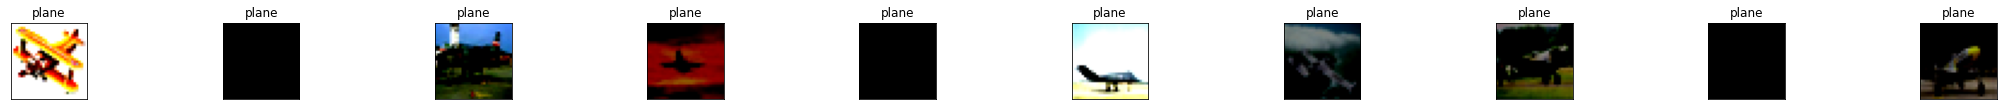

In [ ]:
plane = data_utils.display_cifar_images(modelconfig.trainloader, classname='plane')
fig = plt.figure(figsize=(45,20))
for idx in np.arange(len(plane[:10])):
  ax = fig.add_subplot(12,12, idx+1, xticks=[], yticks=[]) 
  plt.imshow(plane[idx]) #converting to numpy array as plt needs it.
  ax.set_title('plane')


**Class/Batch Balance**

In [ ]:
from collections import defaultdict
data = defaultdict()
for batch_idx, (images, labels) in enumerate(iter(modelconfig.trainloader)):
  data[batch_idx] = labels

total_data = []
first_batch = data[1]
for i in range(len(data)):
  for label in list(data[i]):
   total_data.append(label.item())

class_balance = defaultdict()
class_data = {0,1,2,3,4,5,6,7,8,9}
for i in class_data:
  class_balance[i]=total_data.count(i)
class_balance



defaultdict(None,
            {0: 5000,
             1: 5000,
             2: 5000,
             3: 5000,
             4: 5000,
             5: 5000,
             6: 5000,
             7: 5000,
             8: 5000,
             9: 5000})

All classes have same number of images, 5000. Dataset is balanced. 

In [34]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, config):
        super(Net, self).__init__()
        self.config = config
        self.ch_norm = self.config.channel_norm

    def convblock(self, in_ch=1, mid_ch=8, out_ch=16, kernel_=(3,3), padding_=[0,0], dilation_=[1,1], bias=False):#, ch_norm = self.ch_norm):
        if self.ch_norm == 'BatchNorm2d':
          _block = nn.Sequential(
                                  nn.Conv2d(in_channels=in_ch, out_channels=mid_ch, kernel_size=kernel_, padding=padding_[0], dilation=dilation_[0], bias=False),
                                  nn.ReLU(), 
                                  nn.BatchNorm2d(mid_ch), 
                                  nn.Dropout(self.config.dropout_value),
                                  
                                  nn.Conv2d(in_channels=mid_ch, out_channels=out_ch, kernel_size=kernel_, padding=padding_[1],dilation=dilation_[1], bias=False),
                                  nn.ReLU(), 
                                  nn.BatchNorm2d(out_ch),
                                  nn.Dropout(self.config.dropout_value)
            )
        if self.ch_norm == 'GroupNorm':
            _block = nn.Sequential(
                                    nn.Conv2d(in_channels=in_ch, out_channels=mid_ch, kernel_size=kernel_, padding=padding_[0], dilation=dilation_[0], bias=False),
                                    nn.ReLU(), 
                                    nn.GroupNorm(2, mid_ch), 
                                    nn.Dropout(self.config.dropout_value),
                                    
                                    nn.Conv2d(in_channels=mid_ch, out_channels=out_ch, kernel_size=kernel_, padding=padding_[1],dilation=dilation_[1], bias=False),
                                    nn.ReLU(), 
                                    nn.GroupNorm(2, out_ch),
                                    nn.Dropout(self.config.dropout_value)
            )
        if self.ch_norm == 'LayerNorm':
            _block = nn.Sequential(
                                    nn.Conv2d(in_channels=in_ch, out_channels=mid_ch, kernel_size=kernel_, padding=padding_[0], dilation=dilation_[0], bias=False),
                                    nn.ReLU(), 
                                    nn.GroupNorm(1, mid_ch),
                                    nn.Dropout(self.config.dropout_value),
                                    
                                    nn.Conv2d(in_channels=mid_ch, out_channels=out_ch, kernel_size=kernel_, padding=padding_[1],dilation=dilation_[1], bias=False),
                                    nn.ReLU(), 
                                    nn.GroupNorm(1, out_ch),
                                    nn.Dropout(self.config.dropout_value)
            )
        return _block

    def single_convblock(self, in_ch=1, out_ch=16, kernel_=(3,3), padding_=0, bias_=False):
      if self.ch_norm == 'BatchNorm2d':
            _block = nn.Sequential(nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=kernel_, padding=padding_, bias=bias_),
                                    nn.ReLU(), 
                                    nn.BatchNorm2d(out_ch), 
                                    nn.Dropout(self.config.dropout_value))
            
      if self.ch_norm == 'GroupNorm':
          _block = nn.Sequential(nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=kernel_, padding=padding_, bias=bias_),
                                  nn.ReLU(), 
                                  nn.GroupNorm(2, out_ch), 
                                  nn.Dropout(self.config.dropout_value))
          
      if self.ch_norm == 'LayerNorm':
            _block = nn.Sequential(nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=kernel_, padding=padding_, bias=bias_),
                                  nn.ReLU(), 
                                  nn.GroupNorm(1, out_ch),
                                  nn.Dropout(self.config.dropout_value))
      return _block

    
    def transition_block(self, in_ch=0, out_ch=10, kernel_=(2,2), stride_value=2, bias_=False):
      _block = nn.Sequential(nn.Conv2d(in_channels=in_ch, out_channels=in_ch, kernel_size=kernel_, stride=stride_value, bias=bias_),
                              nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=(1,1), bias=False))
      return _block



class CifarNet(Net):
    def __init__(self):
        super(CifarNet, self).__init__(modelconfig)
        self.conv0 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3,3), padding=2)
        self.conv1 = self.convblock(in_ch=8, mid_ch=16, out_ch=32, padding_=[4,2], dilation_=[2,2]) # RF 5x5
        self.transition1 = self.transition_block(in_ch=32, out_ch=16, kernel_=(3,3), stride_value=2) # RF 
        
        self.conv2 = self.convblock(in_ch=16, mid_ch=32, out_ch=64, padding_=[4,2], dilation_=[2,2]) # RF
        self.transition2 = self.transition_block(in_ch=64, out_ch=16, kernel_=(3,3), stride_value=2) # RF

        self.conv3 = self.convblock(in_ch=16, mid_ch=32, out_ch=64, padding_=[4,2], dilation_=[2,2]) # RF
        self.transition3 = self.transition_block(in_ch=64, out_ch=16, kernel_=(3,3), stride_value=2) # RF

        self.conv4 = self.convblock(in_ch=16, mid_ch=32, out_ch=64, padding_=[2,2], dilation_=[2,2]) # RF
        # self.transition4 = self.transition_block(in_ch=64, out_ch=16, kernel_=(3,3), stride_value=2) # RF


        # self.conv2 = self.convblock(in_ch=16, mid_ch=32, out_ch=64)

        self.gap = nn.AvgPool2d(6)

        self.last_conv = nn.Conv2d(in_channels=64, out_channels=10, kernel_size=(1,1))
        self.fc = self.single_convblock(in_ch=64, out_ch=10, kernel_=(1,1))


    def forward(self, ip):
        conv0 = self.conv0(ip)
        conv1x = self.conv1(conv0)
        # print('conv1x.shape', conv1x.shape)

        transition1x = self.transition1(conv1x)
        # print('transition1x.shape', transition1x.shape)

        conv2x = self.conv2(transition1x)
        # print('conv2x.shape', conv2x.shape)

        transition2x = self.transition2(conv2x)
        # print('transition2x.shape', transition2x.shape)

        conv3x = self.conv3(transition2x)
        # print('conv3x.shape', conv3x.shape)

        transition3x = self.transition3(conv3x)
        # print('transition3x.shape', transition3x.shape)
        
        conv4x = self.conv4(transition3x)
        # print('conv4x.shape', conv4x.shape)
        # print('conv2x.shape', conv2x.shape)
        gap = self.gap(conv4x)
        # # print('gap.shape',gap.shape)
        # fc = self.fc(gap)
        last_conv = self.last_conv(gap)
        # # print('fc.shape',fc.shape)

        final_op = last_conv.view(last_conv.shape[0],-1)

        if self.config.loss_function == 'CrossEntropyLoss':
            return final_op
        elif self.config.loss_function == 'NLLoss':
            return F.log_softmax(final_op, dim=-1)





model = CifarNet().to(modelconfig.device)
summary(model, input_size=modelconfig.input_image_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 34, 34]             224
            Conv2d-2           [-1, 16, 38, 38]           1,152
              ReLU-3           [-1, 16, 38, 38]               0
       BatchNorm2d-4           [-1, 16, 38, 38]              32
           Dropout-5           [-1, 16, 38, 38]               0
            Conv2d-6           [-1, 32, 38, 38]           4,608
              ReLU-7           [-1, 32, 38, 38]               0
       BatchNorm2d-8           [-1, 32, 38, 38]              64
           Dropout-9           [-1, 32, 38, 38]               0
           Conv2d-10           [-1, 32, 18, 18]           9,216
           Conv2d-11           [-1, 16, 18, 18]             512
           Conv2d-12           [-1, 32, 22, 22]           4,608
             ReLU-13           [-1, 32, 22, 22]               0
      BatchNorm2d-14           [-1, 32,

In [35]:

train_misc_img, test_misc_img, model_results = fit(model=model, config=modelconfig)


  0%|          | 0/391 [00:00<?, ?it/s]


EPOCH:  1 LR:  [0.01]


TypeError: ignored

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.185
[1,  4000] loss: 1.848
[1,  6000] loss: 1.678
[1,  8000] loss: 1.573
[1, 10000] loss: 1.524
[1, 12000] loss: 1.480
[2,  2000] loss: 1.399


5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [ ]:
outputs = net(images)

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))